In [1]:
import pandas as pd
import numpy as np
import subprocess as sp
import os

The raw data contains BAM files for each cluster (not copied here), as well as a table of peaks.
We can use these to obtain a table of reads under peaks using gimmemotifs' coverage_table command.

In [2]:
%%bash
source /mnt/sda/alberto/programs/miniconda3/bin/activate
conda activate gimme_venv
coverage_table -h

usage: coverage_table [-h] -p FILE -d [FILE ...] [-w WINDOW] [-l] [-n METHOD]
                      [-t TOP] [-T TOPMETHOD] [-D] [-R] [--nthreads INT]

GimmeMotifs v0.17.1 - coverage_table

optional arguments:
  -h, --help            show this help message and exit
  -p FILE, --peaks FILE
                        BED file containing peaks
  -d [FILE ...], --datafile [FILE ...]
                        data files (BAM, BED or bigWig format)
  -w WINDOW, --window WINDOW
                        window size (default 200)
  -l, --logtransform    Log transfrom
  -n METHOD, --normalization METHOD
                        Normalization: none, quantile or scale
  -t TOP, --top TOP     Select regions.
  -T TOPMETHOD, --topmethod TOPMETHOD
                        Method to select regions (var, std, mean or random)
  -D                    keep duplicate reads (removed by default)
  -R                    keep reads with mapq 0 (removed by default)
  --nthreads INT        Number of threads


With this command we get the reads under peaks, with each peak normalized to 200bp (using the center of each read).

In [3]:
%%bash
source /mnt/sda/alberto/programs/miniconda3/bin/activate
conda activate gimme_venv

# prior to this, we must generate a merge of all bam files: samtools merge merged.bam *.bam
coverage_table \
-p /mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/NX73/outs/raw_peak_bc_matrix/peaks.bed \
-d \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/neoblast.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/early_epidermal_progenitors.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/late_epidermal_progenitors.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/epidermis.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/phagocytes.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/basal_goblet.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/muscle.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/neurons.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/parenchyma.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/protonephridia.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/secretory.bam \
-w 200 \
-n none \
--nthreads 12 \
> /mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/atac_counts_broadtype.tsv

2024-02-08 11:22:46,462 - INFO - Loading data
100%|██████████| 11/11 [00:13<00:00,  1.19s/it]
2024-02-08 11:22:59,596 - INFO - No normalization


# get peak summits & max read depths

The peak file in the raw data has two issues:
  1. the peaks have variable widths
  2. some "peaks" have very few reads
  
Here we make a pileup of all BAM reads to find the number of reads, and the summit of reads under each peak. 

Next, we filter the peakset to peaks which contain at least four reads in total.

Finally, we normalize the peak width too 200bp, centered on the summit.

In [4]:
peakfile = "/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/NX73/outs/raw_peak_bc_matrix/peaks.bed"
df = pd.read_table(peakfile, comment="#", header=None)
df.columns = ["chrom", "start", "end"]
df

,chrom,start,end
0,chr1_h1,38165,39079
1,chr1_h1,39671,40541
2,chr1_h1,64000,64936
3,chr1_h1,65429,66256
4,chr1_h1,267974,268852
...,...,...,...
36512,h1tg000785l,8720,9583
36513,h1tg000695l,5216,6014
36514,h1tg000695l,15215,16132
36515,h1tg000866l,3191,4071


In [5]:
# no comments/headers
df.to_csv("/mnt/sda/alberto/projects/smed_cisreg/outputs/ananse/prep/peaks.bed", sep="\t", index=False, header=False)

Optional: instead of using peaks.bed directly, you can extend the peaks first using bedtools slop. With 1000bp, all peaks have reads but that might be unrealistic. 

In [6]:
%%bash

bedtools slop \
-b 1000 \
-i ~/projects/smed_cisreg/outputs/ananse/prep/peaks.bed \
-g ~/genomes/Smed/Rink/schMedS3/sizes.genome \
> ~/projects/smed_cisreg/outputs/ananse/prep/peaks_extended.bed

In [8]:
%%bash

# -B: Bam already filtered
# -A: Bam already filtered
samtools mpileup \
-A -B \
-l ~/projects/smed_cisreg/outputs/ananse/prep/peaks_extended.bed \
-o ~/projects/smed_cisreg/outputs/ananse/prep/peak_extended_pileup.tsv \
~/projects/smed_cisreg/outputs/ananse/prep/bams/possorted_bam.bam

[mpileup] 1 samples in 1 input files


In [9]:
pu = pd.read_table(
    "~/projects/smed_cisreg/outputs/ananse/prep/peak_extended_pileup.tsv", 
    header=None,
    usecols=[0,1,3],
    names=["chrom", "pos", "count"],
)

pu

,chrom,pos,count
0,chr1_h1,38275,1
1,chr1_h1,38276,1
2,chr1_h1,38277,1
3,chr1_h1,38278,1
4,chr1_h1,38279,1
...,...,...,...
65231969,h1tg000866l,12036,10
65231970,h1tg000866l,12037,10
65231971,h1tg000866l,12038,11
65231972,h1tg000866l,12039,11


In [10]:
summits = []
depths = []
last_chrom = ""
for idx, (chrom, start, end) in df.iterrows():
    if last_chrom != chrom:
        print("chrom:", chrom)  # print progress
        chrom_pu = pu[pu["chrom"] == chrom]
        last_chrom = chrom
    
    sub_pu = chrom_pu[chrom_pu["pos"].between(start, end)]
    maxima = sub_pu["count"] == sub_pu["count"].max()
    if sum(maxima) == 0:
        summit = None
    elif sum(maxima) == 1:
        summit = int(sub_pu[maxima]["pos"])
    else:
        idx = sub_pu[maxima].index
        middle_summit = idx[len(idx) // 2]
        summit = int(sub_pu.loc[middle_summit]["pos"])
    depth = sub_pu["count"].max()
    
    depths.append(depth)
    summits.append(summit)


chrom: chr1_h1
chrom: chr2_h1
chrom: chr3_h1
chrom: chr4_h1
chrom: scaffold_12_h1
chrom: h1tg000124l
chrom: h1tg000207l
chrom: h1tg000152l
chrom: h1tg000155l
chrom: scaffold_16_h1
chrom: h1tg000329l
chrom: h1tg000230l
chrom: h1tg000212l
chrom: h1tg000517l
chrom: h1tg000471l
chrom: h1tg000489l
chrom: h1tg000353l
chrom: h1tg000121l
chrom: h1tg000463l
chrom: h1tg000519l
chrom: scaffold_67_h1
chrom: h1tg000794l
chrom: h1tg000613l
chrom: h1tg000664l
chrom: h1tg000710l
chrom: h1tg000746l
chrom: h1tg000865l
chrom: h1tg000738l
chrom: h1tg000544l
chrom: h1tg000835l
chrom: h1tg000565l
chrom: h1tg000785l
chrom: h1tg000695l
chrom: h1tg000866l


In [11]:
df2 = df.copy()
df2["summit"] = summits
df2["depth"] = depths
df2 = df2.dropna()
df2["summit"] = df2["summit"].astype(np.int64)
df2["depth"] = df2["depth"].astype(np.int64)
df2.head()

,chrom,start,end,summit,depth
0,chr1_h1,38165,39079,38424,26
1,chr1_h1,39671,40541,40010,55
2,chr1_h1,64000,64936,64527,48
3,chr1_h1,65429,66256,65849,42
4,chr1_h1,267974,268852,268523,24


In [12]:
df2.to_csv("~/projects/smed_cisreg/outputs/ananse/prep/peak_extended_summits.tsv", index=False, sep="\t")

# visualize peaks per read depth

In [13]:
df2 = pd.read_csv("~/projects/smed_cisreg/outputs/ananse/prep/peak_extended_summits.tsv", sep="\t")

depth = list(range(0, df2["depth"].max()))
n_regions = []
for n in depth:
    nr = sum(df2['depth'] == n)
    n_regions.append(nr)
    if n <= 10:
        print(
            f"regions with depth {n}: {nr}"
        )


regions with depth 0: 0
regions with depth 1: 0
regions with depth 2: 0
regions with depth 3: 4
regions with depth 4: 82
regions with depth 5: 327
regions with depth 6: 899
regions with depth 7: 1624
regions with depth 8: 2332
regions with depth 9: 2777
regions with depth 10: 2960


In [14]:
import matplotlib
%matplotlib inline

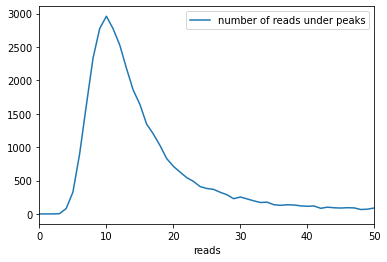

In [15]:
_ = pd.DataFrame({"reads": depth, "number of reads under peaks": n_regions}).plot(x="reads", xlim=(0, 50))#, ylim=(0, 20_000))

In [16]:
min_depth = list(range(0, df2["depth"].max()))
n_regions = []
for n in min_depth:
    nr = sum(df2['depth'] >= n)
    n_regions.append(nr)

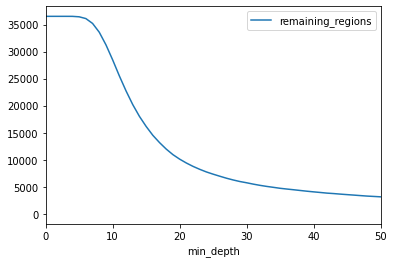

In [17]:
_ = pd.DataFrame({"min_depth": min_depth, "remaining_regions": n_regions}).plot(x="min_depth", xlim=(0, 50))#, ylim=(0, 20_000))

# filter peaks (by min read depth)

In [22]:
min_reads = 5 # should be 4??

In [23]:
df3 = df2.copy()
df3 = df3[df3['depth'] >= min_reads]
# standardize the peak widths
df3["start"] = df3["summit"]-100
df3["end"] = df3["summit"]+100
df3 = df3[["chrom", "start", "end"]]
df3

,chrom,start,end
0,chr1_h1,38324,38524
1,chr1_h1,39910,40110
2,chr1_h1,64427,64627
3,chr1_h1,65749,65949
4,chr1_h1,268423,268623
...,...,...,...
36512,h1tg000785l,9237,9437
36513,h1tg000695l,5532,5732
36514,h1tg000695l,15457,15657
36515,h1tg000866l,3468,3668


In [24]:
df3.to_csv(f"~/projects/smed_cisreg/outputs/ananse/prep/peaks_normalized_min{min_reads}.bed", index=False, header=False, sep="\t")

# make ATAC counts table

In [25]:
%%bash
source /mnt/sda/alberto/programs/miniconda3/bin/activate
conda activate gimme_venv

coverage_table \
-p ~/projects/smed_cisreg/outputs/ananse/prep/peaks_normalized_min10.bed \
-d \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/neoblast.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/early_epidermal_progenitors.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/late_epidermal_progenitors.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/epidermis.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/phagocytes.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/basal_goblet.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/muscle.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/neurons.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/parenchyma.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/protonephridia.bam \
/mnt/sda/alberto/projects/smed_cisreg/outputs/scatac/seurat_outputs/split_bam/secretory.bam \
-w 200 \
-n none \
--nthreads 12 \
> ~/projects/smed_cisreg/outputs/ananse/counts/atac/atac_counts_min5.tsv

2024-02-13 15:20:46,942 - INFO - Loading data
100%|██████████| 11/11 [00:12<00:00,  1.11s/it]
2024-02-13 15:20:59,299 - INFO - No normalization


The End!